# **Analyse, transform, and evaluate the data downloaded**

In [6]:
import extract


Running __init__.py for GoogleFloodHub-data-extractor
GoogleFloodHub-data-extractor initialized



In [7]:
import analyze


Running __init__.py for GoogleFloodHub-data-analyzer
GoogleFloodHub-data-analyzer initialized



In [8]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df_Mali_gauges, df_Mali_gauge_models, df_Mali_forecasts = analyze.get_country_data('Mali', '2024-07-08', '2024-10-08')
df_Kenya_gauges, df_Kenya_gauge_models, df_Kenya_forecasts = analyze.get_country_data('Kenya', '2024-07-10', '2024-10-08')
df_Zambia_gauges, df_Zambia_gauge_models, df_Zambia_forecasts = analyze.get_country_data('Zambia', '2024-07-12', '2024-10-08')

In [10]:
print(len(df_Mali_gauges), len(df_Mali_gauge_models), len(df_Mali_forecasts))
print(len(df_Kenya_gauges), len(df_Kenya_gauge_models), len(df_Kenya_forecasts))
print(len(df_Zambia_gauges), len(df_Zambia_gauge_models), len(df_Zambia_forecasts))

16 16 11776
3 3 2168
46 46 32384


In [11]:
df_Mali_forecasts.columns

Index(['gaugeId', 'issue_date', 'issue_time', 'fc_date', 'fc_value'], dtype='object')

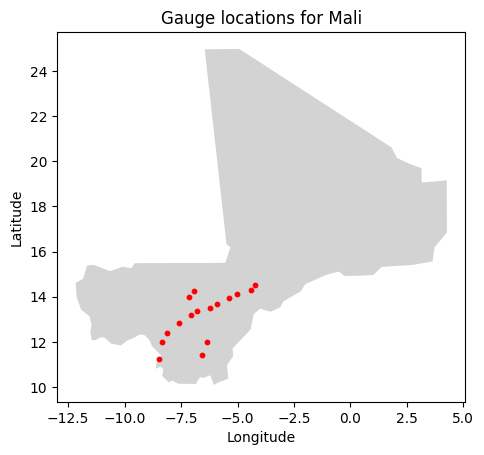

In [12]:
analyze.map_gauge_coordinates_of_country(
    df_Mali_gauges, 'Mali'
)

##### **Identify the gauges near the Niger river:**

In [13]:
df_Mali_gauge_coords = analyze.subset_country_gauge_coords(df_Mali_gauges)
print(df_Mali_gauge_coords)

             gaugeId   latitude  longitude
0   hybas_1120661040  13.985417  -7.152083
1   hybas_1121900350  13.685417  -5.893750
2   hybas_1120650110  14.277083  -6.927083
3   hybas_1121895840  13.956250  -5.360417
4   hybas_1120641660  14.506250  -4.206250
5   hybas_1121905290  13.360417  -6.789583
6   hybas_1120689830  13.210417  -7.077083
7   hybas_1120766460  11.222917  -8.485417
8   hybas_1120705070  12.835417  -7.581250
9   hybas_1120737100  12.018750  -8.322917
10  hybas_1121919510  12.410417  -8.106250
11  hybas_1121893090  14.131250  -5.039583
12  hybas_1120758950  11.427083  -6.581250
13  hybas_1121890140  14.314583  -4.422917
14  hybas_1120739110  11.977083  -6.360417
15  hybas_1120679780  13.493750  -6.202083


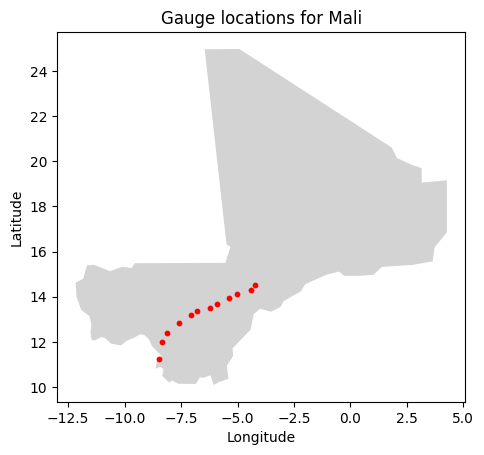

In [14]:
gauges_not_near_Niger = [
    'hybas_1120739110',
    'hybas_1120758950',
    'hybas_1120650110',
    'hybas_1120661040'
]

df_Mali_gauges_Niger = \
    df_Mali_gauges[~df_Mali_gauges['gaugeId'].isin(gauges_not_near_Niger)].copy()

analyze.map_gauge_coordinates_of_country(
    df_Mali_gauges_Niger, 'Mali'
)

In [15]:
df_Mali_gauges_Niger = df_Mali_gauges_Niger.sort_values(
    by = 'latitude',
    ascending = False).reset_index()
print(df_Mali_gauges_Niger['latitude'])

0     14.506250
1     14.314583
2     14.131250
3     13.956250
4     13.685417
5     13.493750
6     13.360417
7     13.210417
8     12.835417
9     12.410417
10    12.018750
11    11.222917
Name: latitude, dtype: float64


No forecasted values for gauge hybas_1120661040 at 2024-08-13


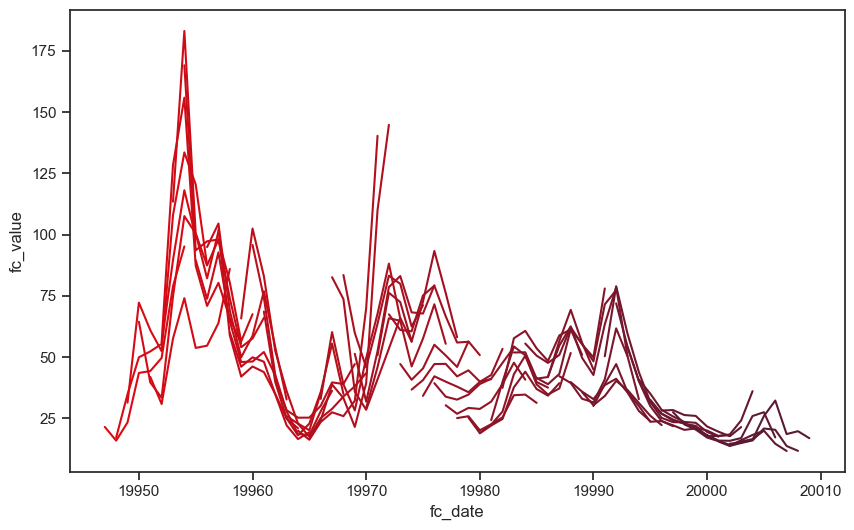

In [16]:
start_date = datetime.datetime.now() - datetime.timedelta(days = 90)

analyze.plot_x_days_of_gauge_forecast_for_issue_time(
    df_Mali_forecasts,                      # plot for Mali
    df_Mali_gauges['gaugeId'].to_list()[0], # plot for the first gauge
    start_date,                             # plot starts 90 days ago (relative to today)
    90,                                     # plot for 90 days (relative to start date)                                                  
    'Mali',                                 # country name (don't forget the capital letter)
)

# **Explorative statistics**

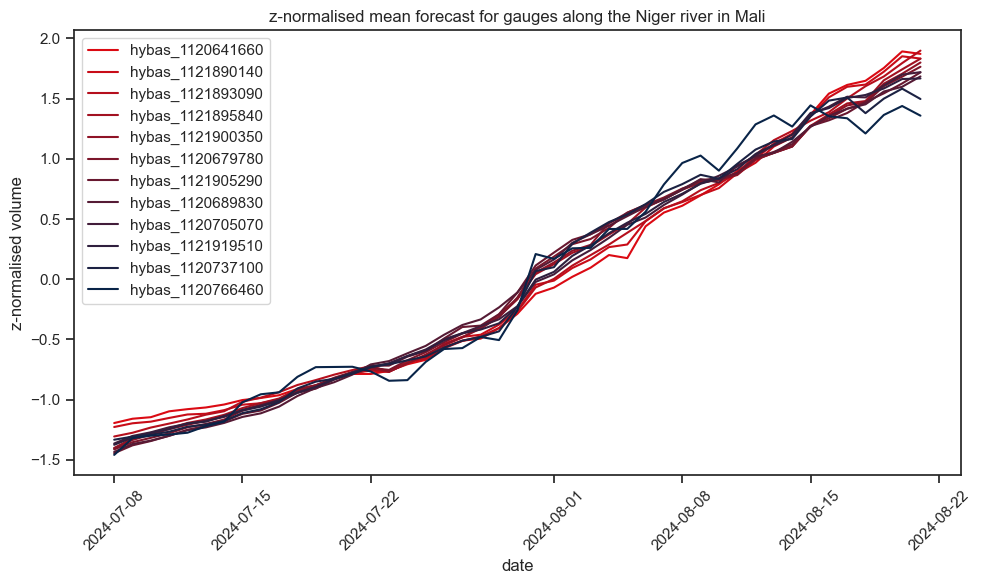

In [17]:
analyze.plot_Niger_river_downstream_flow_stat(
    df_Mali_forecasts,
    datetime.datetime(2024, 7, 8, 0, 0),
    df_Mali_gauges_Niger['gaugeId'].to_list(),
    45,
    'mean'
)

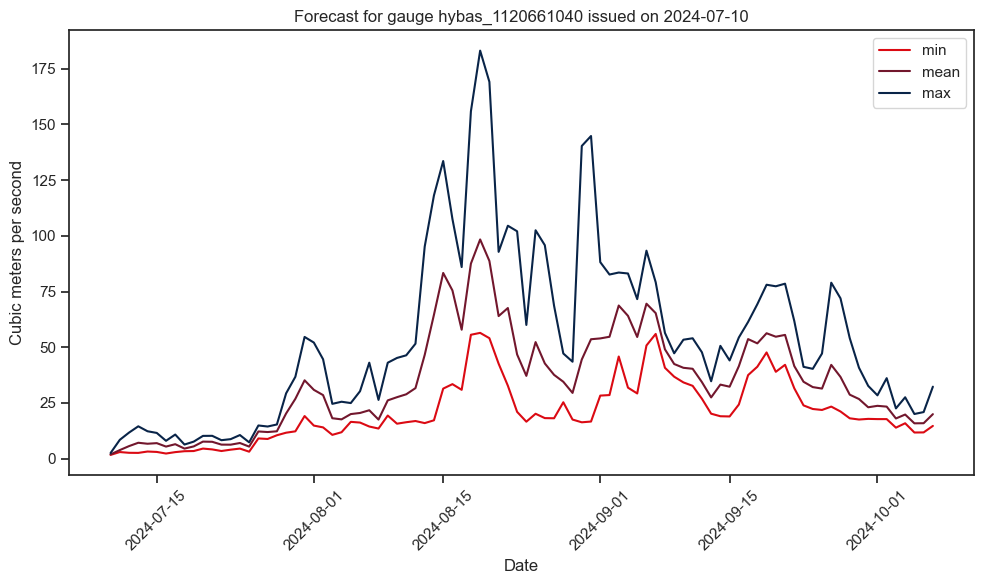

In [18]:
issue_time = datetime.datetime(2024, 10, 8, 0, 0) - datetime.timedelta(days = 90)

analyze.plot_forecast_min_mean_max(
    df_Mali_forecasts,                      # the forecasts
    issue_time,                             # the issue time
    df_Mali_gauges['gaugeId'].to_list()[0], # the gauge
    90                                      # the number of days
)

# **Station-to-administrative-unit classification**

In [ ]:
import geopandas as gpd

# Path to the shape file with admin level 2 units for Mali
path_Mali_shp_adm2 = 'mali_ALL/mli_adm_ab_shp/mli_admbnda_adm2_1m_gov_20211220.shp'
# Read the shape file into a GeoDataFrame and convert it to WGS84
# (which is the coordinate system used by the gauge data)
gpd_adm_units_Mali = analyze.get_shape_file(path_Mali_shp_adm2).to_crs('EPSG:4326')
print(type(gpd_adm_units_Mali)) # Should be a GeoDataFrame

<class 'geopandas.geodataframe.GeoDataFrame'>


In [ ]:
# Create a GeoDataFrame from the gauge coordinates;
# geometry is a point for each gauge, with coords (x, y)
gpd_Mali_gauge_coords = gpd.GeoDataFrame(
    df_Mali_gauge_coords,
    geometry = gpd.points_from_xy(df_Mali_gauge_coords.longitude, df_Mali_gauge_coords.latitude),
    crs = 'EPSG:4326'
)
print(type(gpd_Mali_gauge_coords))

# Check if the coord systems are the same
# (!TODO make this a proper test in tests.py, for after manipulating GeoDataFrames)
if gpd_adm_units_Mali.crs != gpd_Mali_gauge_coords.crs:
    gpd_adm_units_Mal = gpd_adm_units_Mali.to_crs(gpd_Mali_gauge_coords.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>


In [ ]:
# Creates a joined dataframe with the gauges as basis, meaning
# that gauges get assigned to the admin unit they are within,
# including their metadata, such as the shape of the admin unit.
# (And, thus, the rest of the admin units are not considered)
gpd_gauges_classified = gpd.sjoin(
    gpd_Mali_gauge_coords,
    gpd_adm_units_Mali,
    how = 'left', # joins left, i.e. the gauges serve as basis
    predicate = 'within', # checks if the gauge is within the admin unit
    lsuffix = 'gauge',
    rsuffix = 'adm'
)

print(type(gpd_gauges_classified)) # Should be a GeoDataFrame
print(len(gpd_gauges_classified)) # Should print 16, as there are 16 gauges in Mali
print(gpd_gauges_classified.head(2))

<class 'geopandas.geodataframe.GeoDataFrame'>
16
            gaugeId   latitude  longitude                   geometry  \
0  hybas_1120661040  13.985417  -7.152083  POINT (-7.15208 13.98542)   
1  hybas_1121900350  13.685417  -5.893750  POINT (-5.89375 13.68542)   

   index_adm  Shape_Leng  Shape_Area  ADM2_FR ADM2_PCODE ADM2_REF ADM2ALT1FR  \
0        7.0    4.526434    0.657252  Banamba     ML0201     None       None   
1       26.0    6.342597    1.318047    Ségou     ML0406    Segou       None   

  ADM2ALT2FR    ADM1_FR ADM1_PCODE    ADM0_FR ADM0_PCODE       date  \
0       None  Koulikoro       ML02  Mali (le)         ML 2015-06-01   
1       None      Ségou       ML04  Mali (le)         ML 2015-06-01   

     validOn     validTo  
0 2021-12-20  0000/00/00  
1 2021-12-20  0000/00/00  


In [28]:
print(gpd_gauges_classified['gaugeId'])

0     hybas_1120661040
1     hybas_1121900350
2     hybas_1120650110
3     hybas_1121895840
4     hybas_1120641660
5     hybas_1121905290
6     hybas_1120689830
7     hybas_1120766460
8     hybas_1120705070
9     hybas_1120737100
10    hybas_1121919510
11    hybas_1121893090
12    hybas_1120758950
13    hybas_1121890140
14    hybas_1120739110
15    hybas_1120679780
Name: gaugeId, dtype: object


In [22]:
# Save as GEOJSON
gpd_gauges_classified.to_file(
    '../data/processed/gauge_adm_units/mali_gauges_adm_units.geojson',
    driver = 'GeoJSON'
)

In [23]:
# Load GEOJSON back in
gpd_gauges_classified = gpd.read_file(
    '../data/processed/gauge_adm_units/mali_gauges_adm_units.geojson'
)

In [24]:
print(type(gpd_adm_units_Mali))
print(type(gpd_Mali_gauge_coords))
print(gpd_adm_units_Mali.index)
print(gpd_adm_units_Mali.columns)
print(gpd_Mali_gauge_coords.index)
print(gpd_Mali_gauge_coords.columns)

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex(start=0, stop=53, step=1)
Index(['Shape_Leng', 'Shape_Area', 'ADM2_FR', 'ADM2_PCODE', 'ADM2_REF',
       'ADM2ALT1FR', 'ADM2ALT2FR', 'ADM1_FR', 'ADM1_PCODE', 'ADM0_FR',
       'ADM0_PCODE', 'date', 'validOn', 'validTo', 'geometry'],
      dtype='object')
RangeIndex(start=0, stop=16, step=1)
Index(['gaugeId', 'latitude', 'longitude', 'geometry'], dtype='object')


In [31]:
# Now, we want to make a plot where each administrative unit with
# a gauge gets a tinted colour. Thus, we now join the GeoDataFrames
# the other way around, and use the admin units left to plot over
# all off the administrative units

gpd_adm_units_matched = gpd.sjoin(
    gpd_adm_units_Mali,
    gpd_Mali_gauge_coords,
    how = 'left',
    predicate = 'contains',
    # lsuffix = 'adm',
    # rsuffix = 'gauge'
)

print(len(gpd_adm_units_matched))
adm_units_with_gauges = gpd_adm_units_matched.dropna(subset = ['index_right'])
print(adm_units_with_gauges)
print(len(gpd_adm_units_matched))



# fig, ax = plt.subplots(figsize = (10, 10))
# adm_units_Mali.plot(ax = ax, color = 'lightgrey')
# gdf_Mali_gauge_coords.plot(ax = ax, color = 'red')
# plt.show()

58
    Shape_Leng  Shape_Area    ADM2_FR ADM2_PCODE  ADM2_REF ADM2ALT1FR  \
7     4.526434    0.657252    Banamba     ML0201      None       None   
9     3.679644    0.398152    Kangaba     ML0203      None       None   
10    7.702809    1.396836       Kati     ML0204      None       None   
12    4.087357    0.496589  Koulikoro     ML0206      None       None   
12    4.087357    0.496589  Koulikoro     ML0206      None       None   
13    7.757265    2.613239       Nara     ML0207      None       None   
18    6.388038    1.287522    Sikasso     ML0305      None       None   
18    6.388038    1.287522    Sikasso     ML0305      None       None   
23    3.842227    0.542461     Macina     ML0403      None       None   
26    6.342597    1.318047      Ségou     ML0406     Segou       None   
26    6.342597    1.318047      Ségou     ML0406     Segou       None   
26    6.342597    1.318047      Ségou     ML0406     Segou       None   
33    5.438311    0.611429      Mopti     ML0506

In [26]:
import pandas as pd

point_match_GloFAS_to_GFH = pd.read_csv(
    '../data/point_matches/mali_point_match.csv',
    index_col = None,
    sep = ',',
    decimal = '.',
    encoding = 'utf-8'
)

print(point_match_GloFAS_to_GFH.head(2))

  StationName  StationName_x  StationName_y           gaugeId  gaugeId_x  \
0     Tossaye        -3.1796        16.4157  hybas_1120641660   -4.20625   
1    Koryoume        -3.0333        16.6666  hybas_1120641660   -4.20625   

   gaugeId_y  
0   14.50625  
1   14.50625  


# **Calculate Niger cross-correlation and propagation time**

Some issues:
- Is detrending needed? Or, in other words, is non-stationarity a problem?
- The stations aren't spatially uniformly distributed--is this OK?

In [27]:
df_Mali_forecasts

,gaugeId,issue_date,issue_time,fc_date,fc_value
0,hybas_1120641660,2024-07-08,2024-07-08 13:54:03.433896+00:00,2024-07-07,238.515350
1,hybas_1120641660,2024-07-08,2024-07-08 13:54:03.433896+00:00,2024-07-08,247.505783
2,hybas_1120641660,2024-07-08,2024-07-08 13:54:03.433896+00:00,2024-07-09,249.693771
3,hybas_1120641660,2024-07-08,2024-07-08 13:54:03.433896+00:00,2024-07-10,255.613663
4,hybas_1120641660,2024-07-08,2024-07-08 13:54:03.433896+00:00,2024-07-11,272.268463
...,...,...,...,...,...
11771,hybas_1121893090,2024-10-07,2024-10-07 08:51:23.103906+00:00,2024-10-09,3385.522461
11772,hybas_1121893090,2024-10-07,2024-10-07 08:51:23.103906+00:00,2024-10-10,3410.729004
11773,hybas_1121893090,2024-10-07,2024-10-07 08:51:23.103906+00:00,2024-10-11,3454.612305
11774,hybas_1121893090,2024-10-07,2024-10-07 08:51:23.103906+00:00,2024-10-12,3498.025391
